Reordenando el codigo para una mejor comprension

Orden de ejecución para este programa: 

Ejecuta la celda que importa todas las bibliotecas necesarias.
Ejecuta la celda que define las funciones de clean_data.py.
Ejecuta la celda que define las funciones de load_data.py.
Ejecuta la celda que define las funciones de prepare_data_rnn.py.
Ejecuta la celda que define las funciones de train_rnn.py.
Ejecuta la celda que define las funciones de sentiment_analysis.py.
Ejecuta la celda que define la función main.
Finalmente, ejecuta la celda que llama a main() para ejecutar el flujo completo del programa.

Importando las bibliotecas necesarias:

In [2]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from textblob import TextBlob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tkinter as tk
from tkinter import scrolledtext

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\Erick
[nltk_data]     Carreño\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Erick
[nltk_data]     Carreño\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Definir funciones de clean_data.py

In [3]:
def limpiar_caracteres(texto):
    if isinstance(texto, str):
        texto_limpio = re.sub(r'[^a-zA-Z\s]', '', texto, flags=re.I|re.A)
        return texto_limpio.lower()
    else:
        return ''

def tokenizar_texto(texto):
    tokens = word_tokenize(texto)
    return tokens

def eliminar_stopwords(tokens):
    stopwords_esp = set(stopwords.words('spanish'))
    tokens_filtrados = [token for token in tokens if token.lower() not in stopwords_esp]
    return tokens_filtrados

def lematizar_tokens(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens_lemmatizados = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens_lemmatizados

def limpiar_datos():
    archivo_csv = './data/solca_comentarios.csv'
    df = pd.read_csv(archivo_csv, delimiter=',')
    df.rename(columns={'comentario': 'comentarios'}, inplace=True)
    df['comentarios_limpios'] = df['comentarios'].apply(limpiar_caracteres)
    df['tokens'] = df['comentarios_limpios'].apply(tokenizar_texto)
    df['tokens'] = df['tokens'].apply(eliminar_stopwords)
    df['tokens'] = df['tokens'].apply(lematizar_tokens)
    df['sentimiento'] = df['comentarios_limpios'].apply(lambda x: TextBlob(x).sentiment.polarity)
    mostrar_datos_graficos(df)
    return df

def mostrar_datos_graficos(df):
    root = tk.Tk()
    root.title("Datos del CSV y Comentarios Limpios")
    txt_original = scrolledtext.ScrolledText(root, width=80, height=5)
    txt_original.insert(tk.INSERT, "Comentarios originales:\n")
    txt_original.insert(tk.END, df['comentarios'].head().to_string(index=False))
    txt_original.pack()
    txt_limpios = scrolledtext.ScrolledText(root, width=80, height=5)
    txt_limpios.insert(tk.INSERT, "\n\nComentarios después de la limpieza:\n")
    txt_limpios.insert(tk.END, df['tokens'].head().to_string(index=False))
    txt_limpios.pack()
    root.mainloop()


Definir funciones de load_data.py

In [4]:
def mostrar_datos_csv():
    archivo_csv = './data/solca_comentarios.csv'
    df = pd.read_csv(archivo_csv, delimiter=',')
    print(df.head())
    return df


Definir funciones de prepare_data_rnn.py

In [5]:
def preparar_datos_para_rnn(df, max_num_words=10000, max_sequence_length=100):
    tokenizer = Tokenizer(num_words=max_num_words)
    tokenizer.fit_on_texts(df['comentarios_limpios'])
    sequences = tokenizer.texts_to_sequences(df['comentarios_limpios'])
    word_index = tokenizer.word_index
    print(f'Found {len(word_index)} unique tokens.')
    data = pad_sequences(sequences, maxlen=max_sequence_length)
    return data, word_index

def predecir_sentimientos(model, word_index, nuevos_comentarios):
    tokenizer = Tokenizer(num_words=len(word_index))
    tokenizer.word_index = word_index  
    secuencias = tokenizer.texts_to_sequences(nuevos_comentarios)
    datos = pad_sequences(secuencias, maxlen=100)
    predicciones = model.predict(datos)
    return predicciones


Definir funciones de train_rnn.py

In [6]:
def construir_entrenar_modelo_rnn(data, labels):
    x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=64, input_length=data.shape[1]))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])
    return model, history


Definir funciones de sentiment_analysis.py

In [7]:
def visualizar_sentimientos(df):
    if 'sentimiento' not in df.columns:
        raise ValueError("La columna 'sentimiento' no se encuentra en el DataFrame")
    plt.figure(figsize=(10, 6))
    plt.hist(df['sentimiento'], bins=30, edgecolor='black')
    plt.title('Distribución de Sentimientos en los Comentarios')
    plt.xlabel('Polaridad del Sentimiento')
    plt.ylabel('Número de Comentarios')
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_predictions(predicciones, nuevos_comentarios):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(nuevos_comentarios)), predicciones.flatten())
    plt.title('Predicciones de Sentimientos para Nuevos Comentarios')
    plt.xlabel('Índice del Comentario')
    plt.ylabel('Probabilidad de Sentimiento Positivo')
    plt.show()

def realizar_analisis_sentimientos():
    df = limpiar_datos()
    data, tokenizer = preparar_datos_para_rnn(df)
    le = LabelEncoder()
    df['sentimiento_binario'] = le.fit_transform(df['sentimiento'].apply(lambda x: 1 if x >= 0 else 0))
    labels = df['sentimiento_binario'].values
    model, history = construir_entrenar_modelo_rnn(data, labels)
    loss, accuracy = model.evaluate(data, labels)
    print(f'Loss: {loss}, Accuracy: {accuracy}')
    plot_training_history(history)
    visualizar_sentimientos(df)
    nuevos_comentarios = [
        "La salud debería ser gratuita.",
        "Los hospitales públicos son buenos.",
        "Privatizar la salud es peligroso.",
        "Necesitamos mejor atención médica."
    ]
    predicciones = predecir_sentimientos(model, tokenizer, nuevos_comentarios)
    print(f'Predicciones: {predicciones}')
    plot_predictions(predicciones, nuevos_comentarios)


Definir la función principal

                                            idpagina  \
0  SolcaPortoviejo/192107524275402_77066483191030...   
1  SolcaPortoviejo/192107524275402_77066483191030...   
2  SolcaPortoviejo/192107524275402_77066483191030...   
3  SolcaPortoviejo/192107524275402_77065950191083...   
4  SolcaPortoviejo/192107524275402_77063955857949...   

                                          comentario      id  \
0                                                NaN     NaN   
1  Por favor la atención a los pacientes que tien...  1604.0   
2  No están atendiendo a los pacientes derivados ...  1605.0   
3                                                NaN     NaN   
4  Excelente ser humano y un gran profesional el ...  1612.0   

                 fecha  contadorlikes  contadorrespuestas  
0                  NaN            NaN                 NaN  
1  2024-06-08 02:18:12            0.0                 0.0  
2  2024-06-09 00:33:21            0.0                 0.0  
3                  NaN            NaN 

C:\Users\Erick Carreño\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.7192 - loss: 0.6607 - val_accuracy: 1.0000 - val_loss: 0.4860
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9974 - loss: 0.3820 - val_accuracy: 1.0000 - val_loss: 0.0773
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9892 - loss: 0.0777 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9892 - loss: 0.0572 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9964 - loss: 0.0237 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9892 - loss: 0.0642 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9988 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9982 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss:

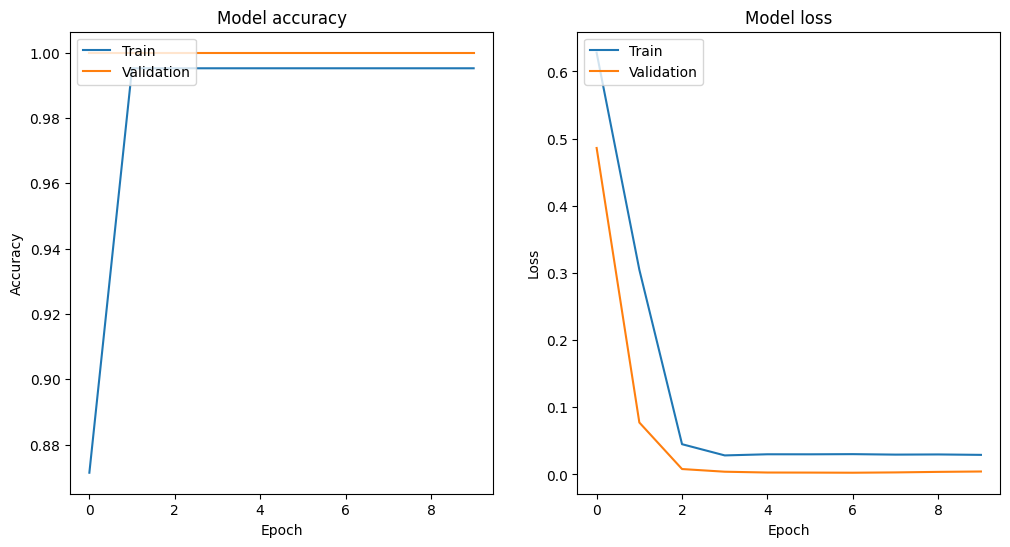

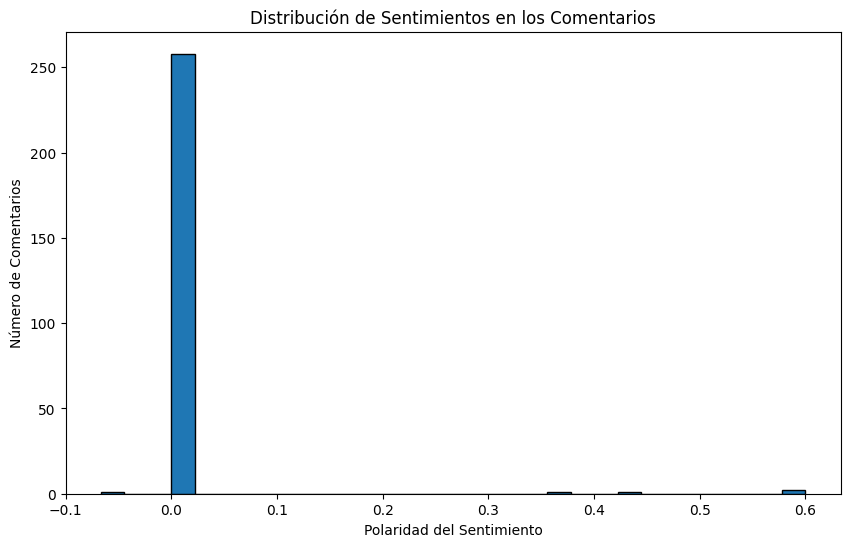

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
Predicciones: [[0.9971932 ]
 [0.9972024 ]
 [0.99730647]
 [0.99729884]]


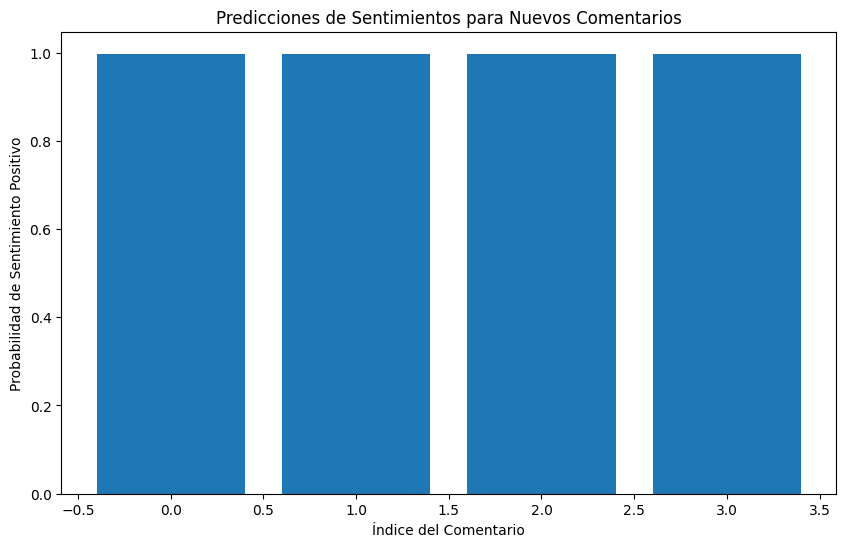

In [8]:
def main():
    df = mostrar_datos_csv()
    df = limpiar_datos()
    realizar_analisis_sentimientos()

if __name__ == "__main__":
    main()


Ejecutar la función principal

In [ ]:
main()
